In [79]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.utils import to_categorical

from bim_method import BIM
from illcm_method import ILLCM
from fgsm_method import FGSM
from jsma_method import JSMA

from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD




In [80]:
plt.rcParams['text.color'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'

## load MNIST dataset

In [81]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

img_rows, img_cols, channels = 28, 28, 1 # 32, 32, 3
num_classes = 10

X_train = X_train / 255
X_test = X_test / 255

X_train = X_train.reshape((-1, img_rows, img_cols, channels))
X_test = X_test.reshape((-1, img_rows, img_cols, channels))

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

## load CIFAR dataset

In [82]:
(X_train_C, y_train_C), (X_test_C, y_test_C) = cifar10.load_data()

img_cols_C, img_rows_C, channels_C = 32, 32, 3
num_classes_C = 10

X_train_C = X_train_C / 255
X_test_C = X_test_C / 255

X_train_C = X_train_C.reshape((-1, img_rows_C, img_cols_C, channels_C))
X_test_C = X_test_C.reshape((-1, img_rows_C, img_cols_C, channels_C))

y_train_C = to_categorical(y_train_C, num_classes_C)
y_test_C = to_categorical(y_test_C, num_classes_C)

labels_C = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## load CIFAR model
   * original model
   * adversarial model

In [83]:
jfile = open("../CNN_model_cifar.json", "r")
loaded_json1 = jfile.read()
jfile.close()
loaded_model1 = model_from_json(loaded_json1)
loaded_model1.load_weights("../CNN_model_cifar.h5")
loaded_model1.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss="categorical_crossentropy", metrics=['accuracy'])

loaded_model1.summary()

Model: "CNN_model_cifar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)    

In [84]:
predictions = loaded_model1.predict(X_test_C)
print(labels[loaded_model1.predict(X_test_C[2].reshape((1, img_rows_C, img_cols_C, channels_C))).argmax()])
pred = list()
for i in range(len(predictions)):
    pred.append(np.argmax(predictions[i]))

test = list()
for i in range(len(y_test_C)):
    test.append(np.argmax(y_test_C[i]))

evaluation = loaded_model1.evaluate(X_test_C, y_test_C)
print(pred, "\n", test)

print("\n%s: %.2f%%" % (loaded_model1.metrics_names[1], evaluation[1]*100))

eight
313/313 [==============================] - 18s 54ms/step - loss: 0.4209 - accuracy: 0.8609

## load MNIST model
   * original model
   * adversarial model

In [85]:
jfile = open("../CNN_model_mnist.json", "r")
loaded_json = jfile.read()
jfile.close()
loaded_model = model_from_json(loaded_json)
loaded_model.load_weights("../CNN_model_mnist.h5")
loaded_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

jfile = open("../CNN_model_mnist_adversarial.json", "r")
loaded_json_adv = jfile.read()
jfile.close()
loaded_model_adv = model_from_json(loaded_json_adv)
loaded_model_adv.load_weights("../CNN_model_mnist_adversarial.h5")
loaded_model_adv.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [86]:
predictions = loaded_model.predict(X_test)
print(labels[loaded_model.predict(X_test[2].reshape((1, img_rows, img_cols, channels))).argmax()])
pred = list()
for i in range(len(predictions)):
    pred.append(np.argmax(predictions[i]))

test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

evaluation = loaded_model.evaluate(X_test, y_test)
print(pred, "\n", test)

print("\n%s: %.2f%%" % (loaded_model.metrics_names[1], evaluation[1]*100))

one
313/313 [==============================] - 2s 4ms/step - loss: 0.0033 - accuracy: 0.9790  

## Basic-Iterative method - BIM:
* Experiments with BIM: MNIST, CIFAR

In [87]:
bim = BIM(0.2, loaded_model)

bim1 = BIM(0.4, loaded_model)

image = X_train[65].reshape((1, img_rows, img_cols, channels))
true_label = y_train[65]

image1 = X_test[315].reshape((1, img_rows, img_cols, channels))
true_label1 = y_test[315]

adv, pert = bim.adversarial_pattern(image, true_label=true_label, alpha=4., iterations=50)
adv1, pert1 = bim1.adversarial_pattern(image1, true_label=true_label1, alpha=6., iterations=50)

## MNIST

Original image: five


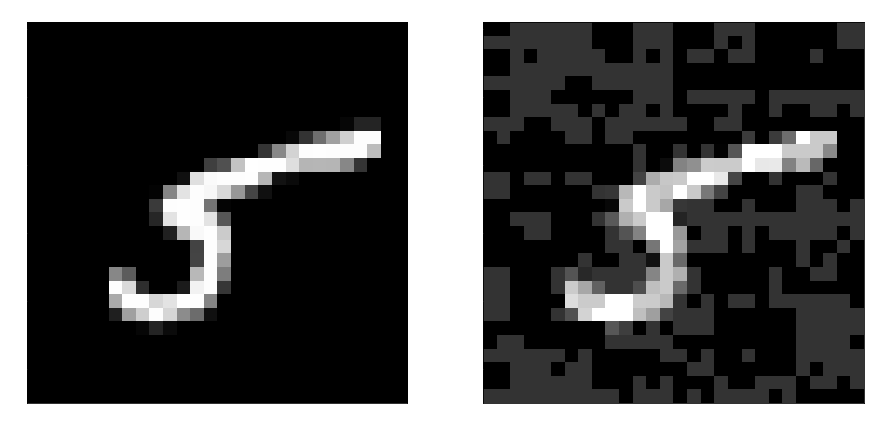

In [88]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.title("Initial image")
plt.imshow(X_train[65].reshape(28, 28), cmap="gray")
print(f"Original image: {labels[np.argmax(y_train[65])]}")

plt.subplot(122)
plt.title("Adversarial image")
plt.imshow(tf.reshape(adv, (28, 28)), cmap="gray")

Original image: nine


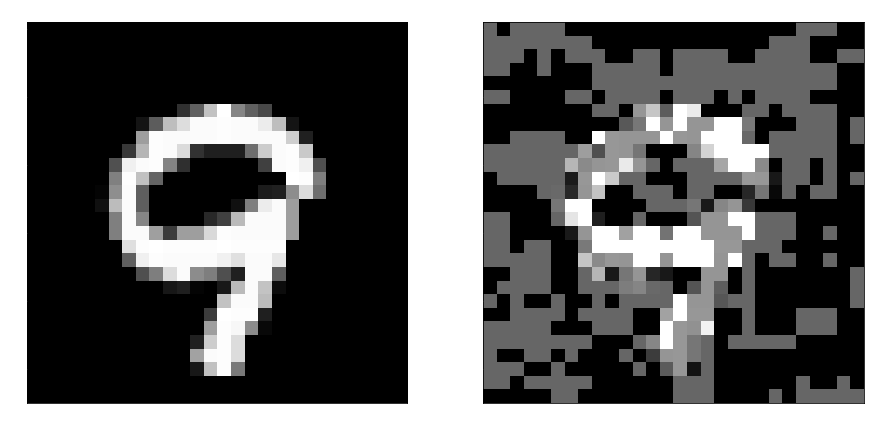

In [89]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.title("Initial image")
plt.imshow(X_test[315].reshape(28, 28), cmap="gray")
print(f"Original image: {labels[np.argmax(y_test[315])]}")

plt.subplot(122)
plt.title("Adversarial image")
plt.imshow(tf.reshape(adv1, (28, 28)), cmap="gray")

In [91]:
print(f"Prediction of original network on adversarial image: {labels[loaded_model.predict(adv).argmax()]}")
print(f"Prediction of adversarial network on adversarial image: {labels[loaded_model_adv.predict(adv).argmax()]}")

Prediction of original network on adversarial image: three
Prediction of adversarial network on adversarial image: five


In [92]:
print(f"Prediction of original network on adversarial image: {labels[loaded_model.predict(adv1).argmax()]}")
print(f"Prediction of adversarial network on adversarial image: {labels[loaded_model_adv.predict(adv1).argmax()]}")

Prediction of original network on adversarial image: four
Prediction of adversarial network on adversarial image: four


## CIFAR

In [ ]:
import cv2

plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.title("Initial image")
plt.imshow(cv2.resize(X_test_C[44], (250, 250), interpolation=cv2.INTER_LINEAR))
print(f"Original image: {labels_C[np.argmax(y_test_C[44])]}")

plt.subplot(122)
plt.title("Target image")
plt.imshow(cv2.resize(X_test_C[45], (250, 250), interpolation=cv2.INTER_LINEAR))
print(f"Target image: {labels_C[np.argmax(y_test_C[45])]}")

In [94]:
bim = BIM(0.05, loaded_model1)

image = X_test_C[44].reshape((1, img_rows_C, img_cols_C, channels_C))
true_label = y_test_C[44]

image1 = X_test_C[45].reshape((1, img_rows_C, img_cols_C, channels_C))
true_label1 = y_test_C[45]

adv1, pert1 = bim.adversarial_pattern(image, true_label=true_label, alpha=0.8, iterations=40)
adv2, pert2 = bim.adversarial_pattern(image1, true_label=true_label1, alpha=2., iterations=40)

Original image: airplane


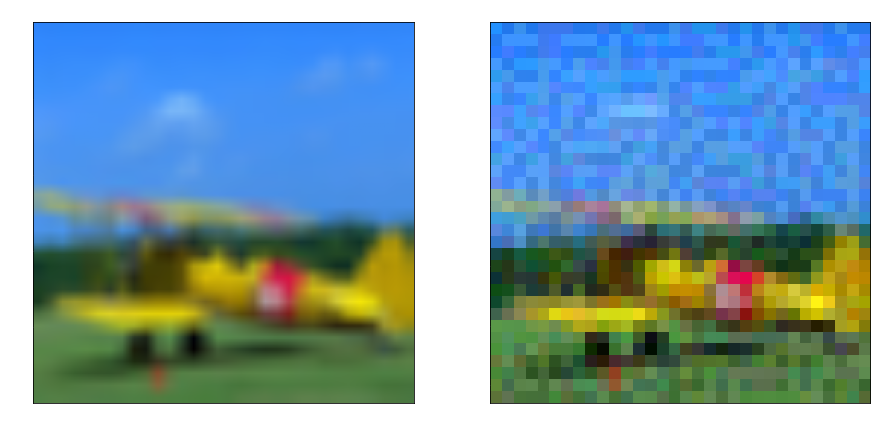

In [95]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.title("Initial image")
plt.imshow(cv2.resize(X_test_C[44], (250, 250), interpolation=cv2.INTER_LINEAR))
print(f"Original image: {labels_C[np.argmax(y_test_C[44])]}")

plt.subplot(122)
plt.title("Adversarial image")
plt.imshow(tf.reshape(adv1, (32, 32, 3)))

Original image: truck


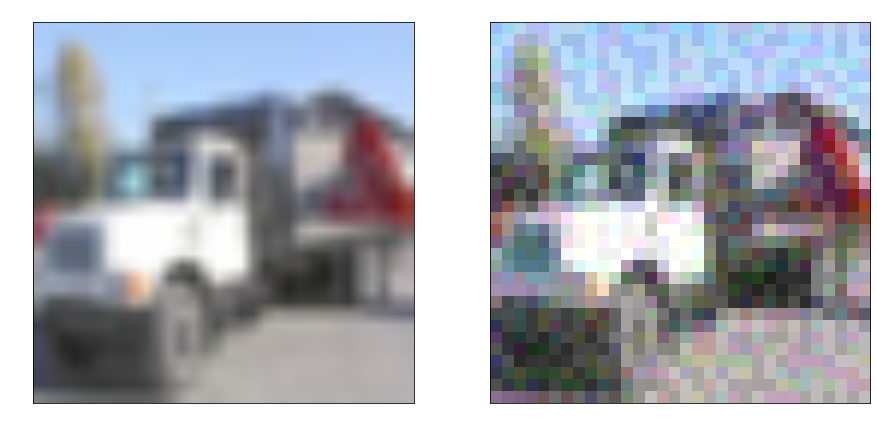

In [96]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.title("Initial image")
plt.imshow(cv2.resize(X_test_C[45], (250, 250), interpolation=cv2.INTER_LINEAR))
print(f"Original image: {labels_C[np.argmax(y_test_C[45])]}")

plt.subplot(122)
plt.title("Adversarial image")
plt.imshow(tf.reshape(adv2, (32, 32, 3)))

In [97]:
print(f"Prediction of original network on adversarial image: {labels_C[loaded_model1.predict(adv1).argmax()]}")

Prediction of original network on adversarial image: truck


In [98]:
print(f"Prediction of original network on adversarial image: {labels_C[loaded_model1.predict(adv2).argmax()]}")

Prediction of original network on adversarial image: frog


## Iterative Least-Likely Class Method - ILLCM
   * experiments with ILLCM:MNIST, CIFAR

In [99]:
illcm = ILLCM(0.25, loaded_model)

image = X_test[125].reshape((1, img_rows, img_cols, channels))
image1 = X_test[101].reshape((1, img_rows, img_cols, channels))

adv1, Y_ll = illcm.adversarial_pattern(image, alpha=0.25*70, iterations=40)
adv2, Y_ll1 = illcm.adversarial_pattern(image1, alpha=4., iterations=50)

## MNIST

Target image №1 according to ILLCM algorithm: 2


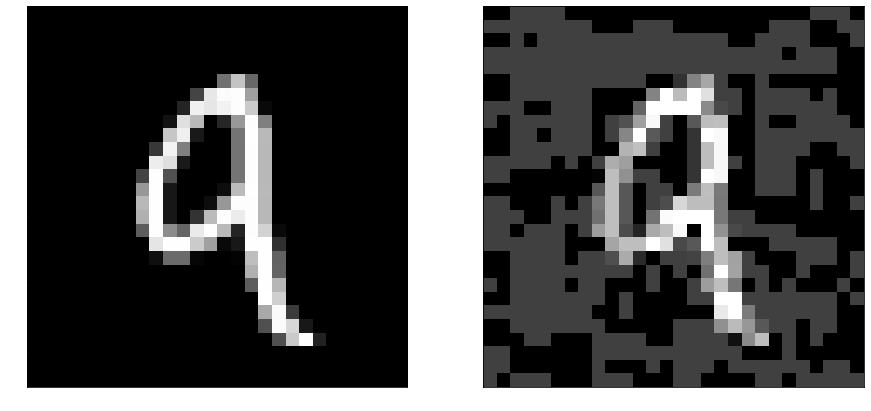

In [100]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.imshow(X_test[125].reshape(28, 28), cmap="gray")
print(f"Target image №1 according to ILLCM algorithm: {Y_ll}")

plt.subplot(122)
plt.imshow(tf.reshape(adv1, shape=(28, 28)), cmap="gray")

Target image №1 according to ILLCM algorithm: 3


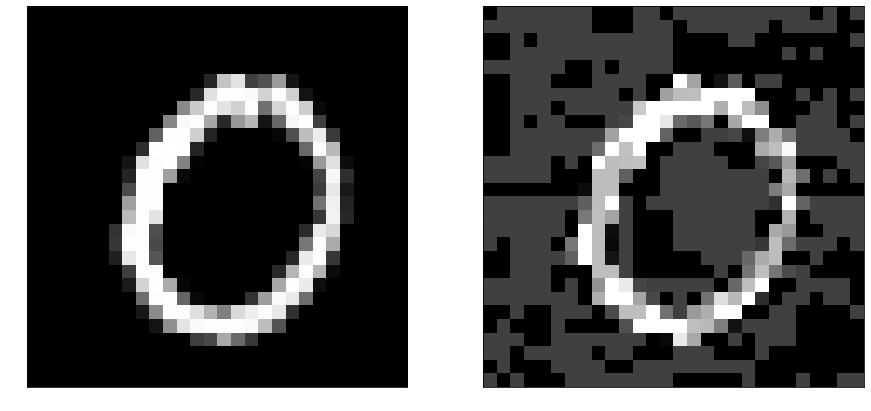

In [101]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.imshow(X_test[101].reshape(28, 28), cmap="gray")
print(f"Target image №1 according to ILLCM algorithm: {Y_ll1}")

plt.subplot(122)
plt.imshow(tf.reshape(adv2, shape=(28, 28)), cmap="gray")

In [102]:
print(f"Prediction of original network on adversarial image: {loaded_model.predict(tf.reshape(adv1, (1, img_cols, img_rows, channels))).argmax()}")
print(f"Prediction of adversarial network on adversarial image: {loaded_model_adv.predict(tf.reshape(adv1, (1, img_cols, img_rows, channels))).argmax()}")

Prediction of original network on adversarial image: 2
Prediction of adversarial network on adversarial image: 8


In [103]:
print(f"Prediction of original network on adversarial image: {loaded_model.predict(tf.reshape(adv2, (1, img_cols, img_rows, channels))).argmax()}")
print(f"Prediction of adversarial network on adversarial image: {loaded_model_adv.predict(tf.reshape(adv2, (1, img_cols, img_rows, channels))).argmax()}")

Prediction of original network on adversarial image: 3
Prediction of adversarial network on adversarial image: 0


## CIFAR

In [182]:
illcm = ILLCM(0.05, loaded_model1)
illcm1 = ILLCM(0.085, loaded_model1)
illcm2 = ILLCM(0.06, loaded_model1)

image_C = X_test_C[89].reshape((1, img_rows_C, img_cols_C, channels_C))
image_C1 = X_test_C[895].reshape((1, img_rows_C, img_cols_C, channels_C))
image_C2 = X_test_C[312].reshape((1, img_rows_C, img_cols_C, channels_C))

adv_C1, Y_ll_C = illcm.adversarial_pattern(image_C, alpha=0.05*80, iterations=70)
adv_C2, Y_ll_C1 = illcm1.adversarial_pattern(image_C1, alpha=0.085*90, iterations=80)
adv_C3, Y_ll_C2 = illcm2.adversarial_pattern(image_C2, alpha=0.06*70, iterations=60)

Target image №1 according to ILLCM algorithm: deer


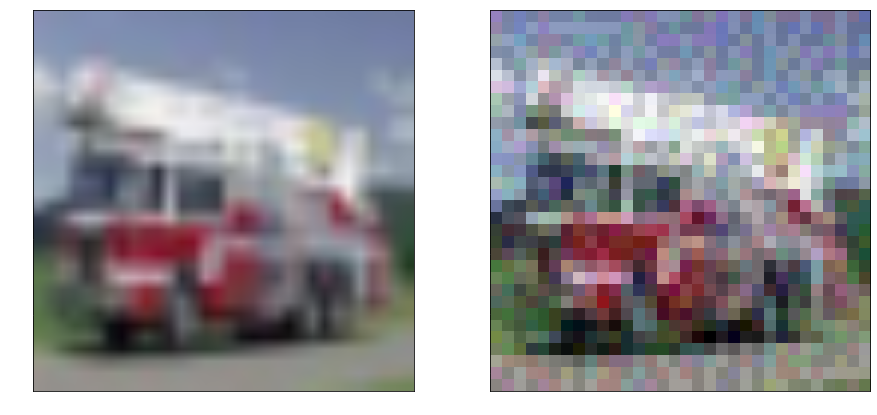

In [105]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.imshow(cv2.resize(X_test_C[89], (250, 250), interpolation=cv2.INTER_LINEAR), cmap="gray")
print(f"Target image №1 according to ILLCM algorithm: {labels_C[Y_ll_C]}")

plt.subplot(122)
plt.imshow(tf.reshape(adv_C1, shape=(img_rows_C, img_cols_C, channels_C)), cmap="gray")

Target image №1 according to ILLCM algorithm: deer


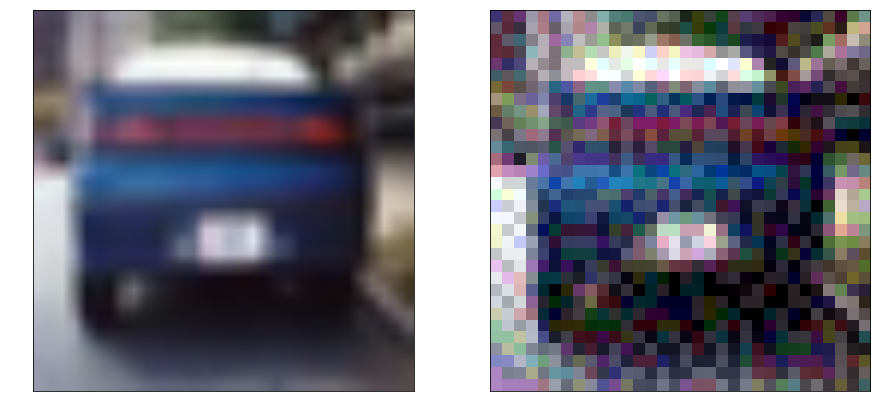

In [137]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.imshow(cv2.resize(X_test_C[895], (250, 250), interpolation=cv2.INTER_LINEAR), cmap="gray")
print(f"Target image №2 according to ILLCM algorithm: {labels_C[Y_ll_C1]}")

plt.subplot(122)
plt.imshow(tf.reshape(adv_C2, shape=(img_rows_C, img_cols_C, channels_C)), cmap="gray")

Target image №1 according to ILLCM algorithm: dog


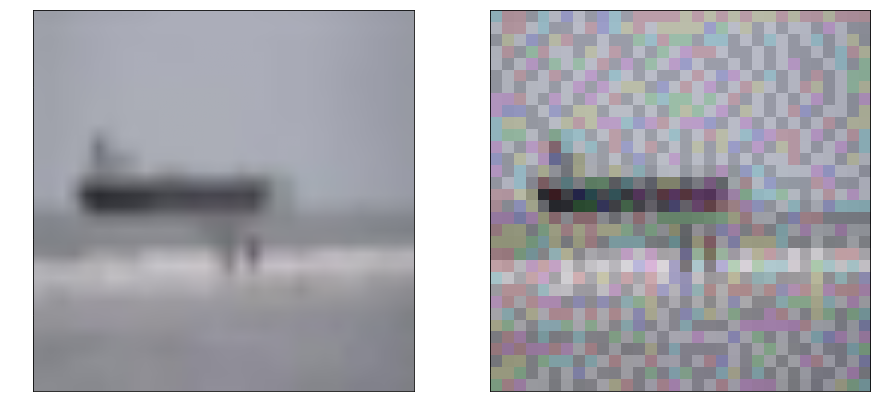

In [183]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.imshow(cv2.resize(X_test_C[312], (250, 250), interpolation=cv2.INTER_LINEAR), cmap="gray")
print(f"Target image №3 according to ILLCM algorithm: {labels_C[Y_ll_C2]}")

plt.subplot(122)
plt.imshow(tf.reshape(adv_C3, shape=(img_rows_C, img_cols_C, channels_C)), cmap="gray")

In [107]:
print(f"Prediction of original network on adversarial image: {labels_C[loaded_model1.predict(tf.reshape(adv_C1, (1, img_cols_C, img_rows_C, channels_C))).argmax()]}")

Prediction of original network on adversarial image: deer


In [138]:
print(f"Prediction of original network on adversarial image: {labels_C[loaded_model1.predict(tf.reshape(adv_C2, (1, img_cols_C, img_rows_C, channels_C))).argmax()]}")


Prediction of original network on adversarial image: truck


In [185]:
print(f"Prediction of original network on adversarial image: {labels_C[loaded_model1.predict(tf.reshape(adv_C3, (1, img_cols_C, img_rows_C, channels_C))).argmax()]}")


Prediction of original network on adversarial image: bird


## Fast-Gradient Sign Method - FGSM:
   * Experiments with FGSM: MNIST, CIFAR

In [109]:
fgsm = FGSM(0.6, loaded_model)
fgsm1 = FGSM(0.9, loaded_model)

image = X_test[5].reshape((1, img_rows, img_cols, channels))
true_label = y_test[5]
image1 = X_test[600].reshape((1, img_rows, img_cols, channels))
true_label1 = y_test[600]

adv_F, pert_F = fgsm.adversarial_pattern(image, true_label=true_label)
adv_F1, pert_F1 = fgsm1.adversarial_pattern(image1, true_label=true_label1)

(10,)
(10,)


## MNIST

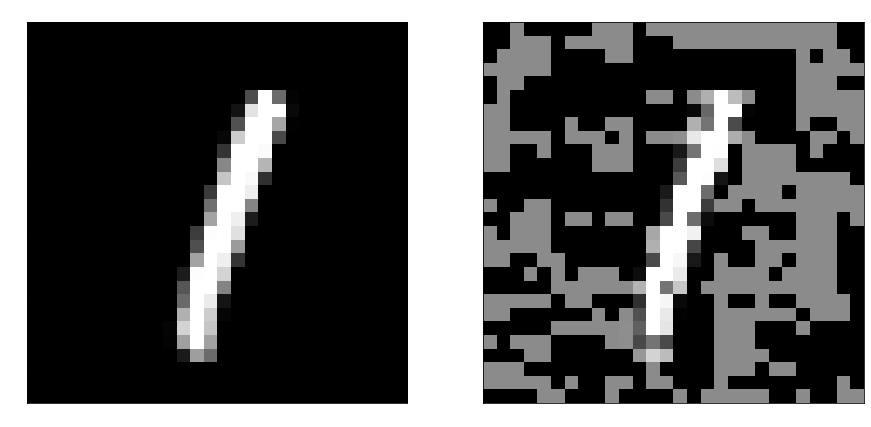

In [110]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.title("Initial image")
plt.imshow(image.reshape(28, 28), cmap="gray")

plt.subplot(122)
plt.title("Adversarial image")
plt.imshow(tf.reshape(adv_F, (img_rows, img_cols, channels)), cmap="gray")

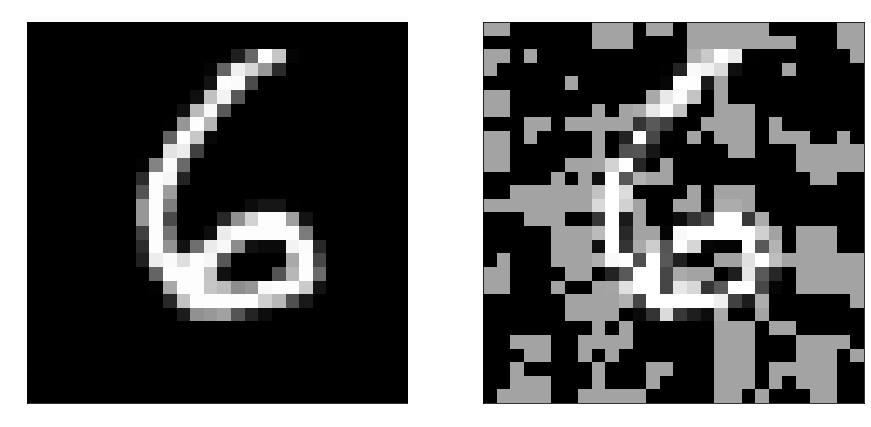

In [111]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.title("Initial image")
plt.imshow(image1.reshape(28, 28), cmap="gray")

plt.subplot(122)
plt.title("Adversarial image")
plt.imshow(tf.reshape(adv_F1, (img_rows, img_cols, channels)), cmap="gray")

In [112]:
print(f"Prediction of original network on adversarial image: {labels[loaded_model.predict(adv_F).argmax()]}")
print(f"Prediction of adversarial network on adversarial image: {labels[loaded_model_adv.predict(tf.reshape(adv_F, (1, img_cols, img_rows, channels))).argmax()]}")

Prediction of original network on adversarial image: seven
Prediction of adversarial network on adversarial image: one


In [113]:
print(f"Prediction of original network on adversarial image: {labels[loaded_model.predict(adv_F1).argmax()]}")
print(f"Prediction of adversarial network on adversarial image: {labels[loaded_model_adv.predict(tf.reshape(adv_F1, (1, img_cols, img_rows, channels))).argmax()]}")

Prediction of original network on adversarial image: five
Prediction of adversarial network on adversarial image: six


## CIFAR

In [114]:
fgsm = FGSM(0.08, loaded_model1)
fgsm1 = FGSM(0.1, loaded_model1)

image_C = X_test_C[9].reshape((1, img_rows_C, img_cols_C, channels_C))
true_label_C = y_test_C[9]
image_C1 = X_test_C[434].reshape((1, img_rows_C, img_cols_C, channels_C))
true_label_C1 = y_test_C[434]

adv_FC, pert_FC = fgsm.adversarial_pattern(image_C, true_label=true_label_C)
adv_FC1, pert_FC1 = fgsm1.adversarial_pattern(image_C1, true_label=true_label_C1)

(10,)
(10,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image: automobile


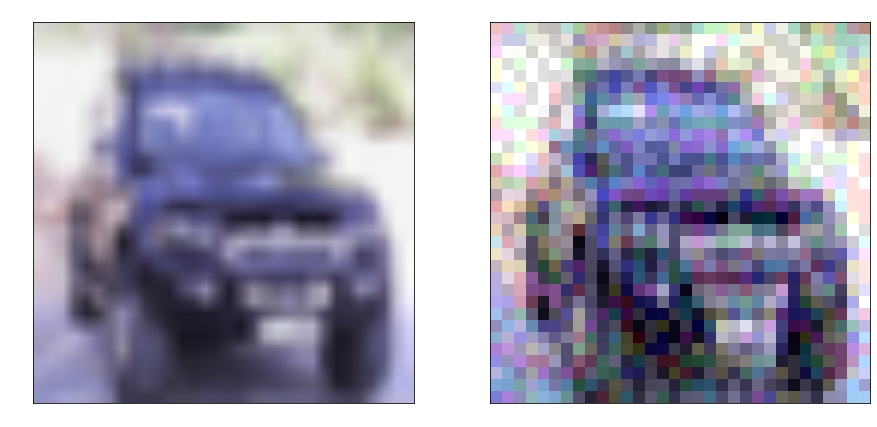

In [115]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.title("Initial image")
plt.imshow(cv2.resize(X_test_C[9], (250, 250), interpolation=cv2.INTER_LINEAR), cmap="gray")

print(f"Original image: {labels_C[np.argmax(y_test_C[9])]}")

plt.subplot(122)
plt.title("Adversarial image")
plt.imshow(tf.reshape(adv_FC, (img_rows_C, img_cols_C, channels_C)), cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image: cat


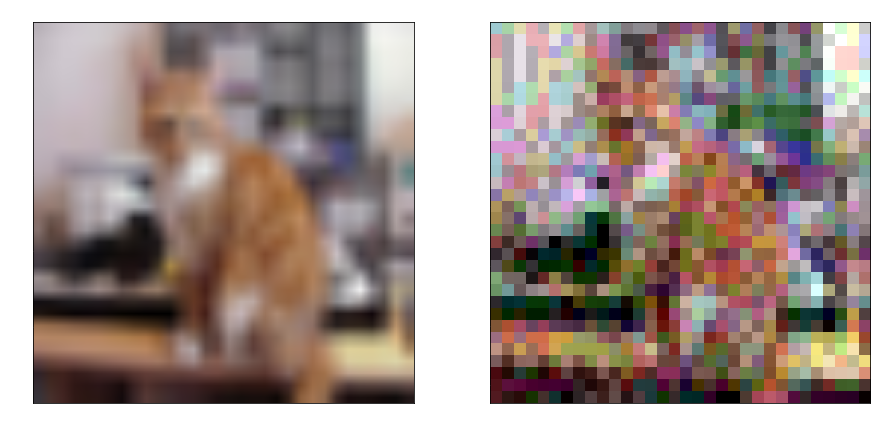

In [116]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.title("Initial image")
plt.imshow(cv2.resize(X_test_C[434], (250, 250), interpolation=cv2.INTER_LINEAR), cmap="gray")
print(f"Original image: {labels_C[np.argmax(y_test_C[434])]}")

plt.subplot(122)
plt.title("Adversarial image")
plt.imshow(tf.reshape(adv_FC1, (img_rows_C, img_cols_C, channels_C)), cmap="gray")

In [117]:
print(f"Prediction of original network on adversarial image: {labels_C[loaded_model1.predict(tf.reshape(adv_FC, (1, img_cols_C, img_rows_C, channels_C))).argmax()]}")

Prediction of original network on adversarial image: truck


In [118]:
print(f"Prediction of original network on adversarial image: {labels_C[loaded_model1.predict(tf.reshape(adv_FC1, (1, img_cols_C, img_rows_C, channels_C))).argmax()]}")

Prediction of original network on adversarial image: frog


## Jacobian-based Saliency Map Attack experiments - JSMA:
   * experiments with JSMA:MNIST, CIFAR

In [186]:
jsma = JSMA(img_rows, img_cols, channels, 1.0, loaded_model)


image = X_test[72].reshape((1, img_rows, img_cols, channels))
target = X_test[54].reshape((1, img_rows, img_cols, channels))

image1 = X_test[35].reshape((1, img_rows, img_cols, channels))
target1 = X_test[58].reshape((1, img_rows, img_cols, channels))

adv_J, pert_J = jsma.adversarial_pattern(image, target_image=target, y_inidx=np.argmax(y_test[72]),
                                          y_tidx=np.argmax(y_test[54]), max_iter=90)
adv_J1, pert_J1 = jsma.adversarial_pattern(image1, target_image=target1, y_inidx=np.argmax(y_test[122]),
                                           y_tidx=np.argmax(y_test[58]), max_iter=130)

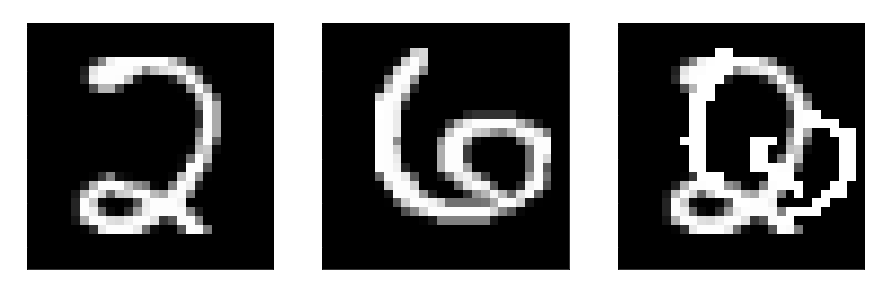

In [187]:
plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.title("Initial image")
plt.imshow(X_test[72], cmap="gray")

plt.subplot(132)
plt.title("Target image")
plt.imshow(X_test[54], cmap="gray")

plt.subplot(133)
plt.title("Adversarial image")
plt.imshow(adv_J.reshape(28, 28), cmap="gray")

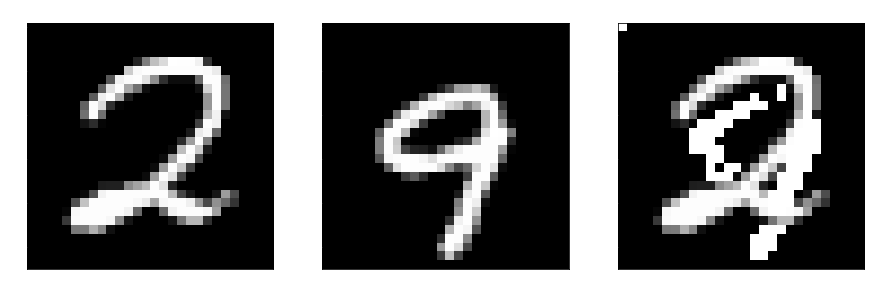

In [188]:
plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.title("Initial image")
plt.imshow(X_test[35], cmap="gray")

plt.subplot(132)
plt.title("Target image")
plt.imshow(X_test[58], cmap="gray")

plt.subplot(133)
plt.title("Adversarial image")
plt.imshow(adv_J1.reshape(28, 28), cmap="gray")

In [189]:
print(f"Prediction of original model on adversarial image: {labels[loaded_model.predict(tf.reshape(adv_J, shape=(1, img_cols, img_rows, channels))).argmax()]}")
print(f"Prediction of adversarial model on adversarial model: {labels[loaded_model_adv.predict(tf.reshape(adv_J, shape=(1, img_cols, img_rows, channels))).argmax()]}")

Prediction of original model on adversarial image: six
Prediction of adversarial model on adversarial model: zero


In [190]:
print(f"Prediction of original model on adversarial image: {labels[loaded_model.predict(tf.reshape(adv_J1, shape=(1, img_cols, img_rows, channels))).argmax()]}")
print(f"Prediction of adversarial model on adversarial model: {labels[loaded_model_adv.predict(tf.reshape(adv_J1, shape=(1, img_cols, img_rows, channels))).argmax()]}")

Prediction of original model on adversarial image: nine
Prediction of adversarial model on adversarial model: eight


## CIFAR

In [191]:
jsma_C = JSMA(img_rows_C, img_cols_C, channels_C, 1.0, loaded_model1)


image_C = X_test_C[91].reshape((1, img_rows_C, img_cols_C, channels_C))
target_C = X_test_C[65].reshape((1, img_rows_C, img_cols_C, channels_C))

image_C1 = X_test_C[126].reshape((1, img_rows_C, img_cols_C, channels_C))
target_C1 = X_test_C[47].reshape((1, img_rows_C, img_cols_C, channels_C))

adv_JC, pert_JC = jsma_C.adversarial_pattern(image_C, target_image=target_C, y_inidx=np.argmax(y_test_C[91]),
                                          y_tidx=np.argmax(y_test_C[65]), max_iter=300)
adv_JC1, pert_JC1 = jsma_C.adversarial_pattern(image_C1, target_image=target_C1, y_inidx=np.argmax(y_test_C[126]),
                                           y_tidx=np.argmax(y_test_C[47]), max_iter=390)

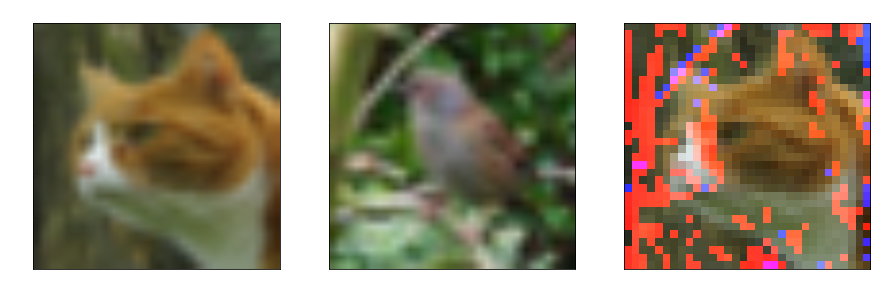

In [192]:
plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.title("Initial image")
plt.imshow(cv2.resize(X_test_C[91], (250, 250), interpolation=cv2.INTER_LINEAR), cmap="gray")

plt.subplot(132)
plt.title("Target image")
plt.imshow(cv2.resize(X_test_C[65], (250, 250), interpolation=cv2.INTER_LINEAR), cmap="gray")

plt.subplot(133)
plt.title("Adversarial image")
plt.imshow(adv_JC.reshape(img_rows_C, img_rows_C, channels_C), cmap="gray")

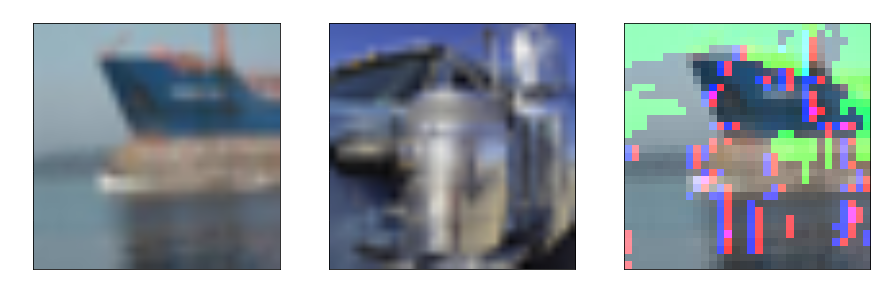

In [193]:
plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.title("Initial image")
plt.imshow(cv2.resize(X_test_C[126], (250, 250), interpolation=cv2.INTER_LINEAR), cmap="gray")

plt.subplot(132)
plt.title("Target image")
plt.imshow(cv2.resize(X_test_C[47], (250, 250), interpolation=cv2.INTER_LINEAR), cmap="gray")

plt.subplot(133)
plt.title("Adversarial image")
plt.imshow(adv_JC1.reshape(img_rows_C, img_rows_C, channels_C), cmap="gray")

In [194]:
print(f"Prediction of original model on adversarial image: {labels_C[loaded_model1.predict(tf.reshape(adv_JC, shape=(1, img_cols_C, img_rows_C, channels_C))).argmax()]}")
# print(f"Prediction of adversarial model on adversarial model: {labels_C[loaded_model_adv.predict(tf.reshape(adv_J, shape=(1, img_cols, img_rows, channels))).argmax()]}")

Prediction of original model on adversarial image: bird


In [195]:
print(f"Prediction of original model on adversarial image: {labels_C[loaded_model1.predict(tf.reshape(adv_JC1, shape=(1, img_cols_C, img_rows_C, channels_C))).argmax()]}")


Prediction of original model on adversarial image: truck
